Test:
- data that should be very strongly correlated, but do not share words
- paragraph describing word, vs actual word embedding


In [22]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from structure import scriptures_structure
import pandas as pd
import os

In [2]:
def get_label(index, indexes, text):
    # Need to add dimension to indexes
    #print(len(indexes.shape))
    if len(indexes.shape) != 1:
        text_indices = indexes[index]
    else:
        text_indices = indexes
    #print(index)
    #print('indexes: ', indexes)
    #print(text)
    #print('text indices: ', text_indices)
    chunk = text[text_indices[0]:text_indices[1]]
    verse = text_indices[2]
    return chunk, verse

In [3]:
def generate_all_labels(index, indexes, text):
    labels = []
    for i in range(index):
        label, verse = get_label(i, indexes, text)
        labels.append(label)
    return labels

In [19]:
# Get highest matches + heatmap for given sliding window size and width
def evaluate_data(path_1, path_2, w_1, w_2, i_1, i_2, threshold=-9999, normalized=True):

    with open(path_1+'.txt') as f:
        text_1 = f.read()

    with open(path_2+'.txt') as f:
        text_2 = f.read()


    if normalized:
        embedding_path_1 = path_1+".w"+w_1+".i"+i_1+".embeddings.normalized.csv"
        index_path_1 = path_1+".w"+w_1+".i"+i_1+".offsets.csv"
        embedding_path_2 = path_2+".w"+w_2+".i"+i_2+".embeddings.normalized.csv"
        index_path_2 = path_2+".w"+w_2+".i"+i_2+".offsets.csv"
    else: 
        embedding_path_1 = path_1+".w"+w_1+".i"+i_1+".embeddings.csv"
        index_path_1 = path_1+".w"+w_1+".i"+i_1+".offsets.csv"
        embedding_path_2 = path_2+".w"+w_2+".i"+i_2+".embeddings.csv"
        index_path_2 = path_2+".w"+w_2+".i"+i_2+".offsets.csv"
    
    data_1 = np.genfromtxt(embedding_path_1,delimiter=',')
    data_2 = np.expand_dims(np.genfromtxt(embedding_path_2,delimiter=','), axis=0)

    indexes_1 = np.genfromtxt(index_path_1,delimiter=',', dtype=int)
    indexes_2 = np.genfromtxt(index_path_2,delimiter=',', dtype=int)

    cos_sim = dot(data_1, data_2.transpose())/(norm(data_1)*norm(data_2))
    # Cos sim should be n x 1 if data2 is just a word
    #print('COS SIM: ', cos_sim.shape)
    # If it's against one word, add a dimension
    #cos_sim = np.expand_dims(cos_sim, axis=0)
    #print('COS SIM: ', cos_sim.shape)
    result_dict = {}

    num = 0
    for i in range(cos_sim.shape[0]):
        for j in range(cos_sim.shape[1]):
            cos_sim_val = cos_sim[i, j]
            if cos_sim_val >= threshold:
                num += 1
                line_1, verse_1 = get_label(i, indexes_1, text_1)
                line_2, verse_2 = get_label(j, indexes_2, text_2)

                # Save to dict
                result_dict[cos_sim_val] = (line_1, line_2, verse_1, verse_2)


    print('Number found: ', num)

    sorted_dict = sorted(result_dict, reverse=True)
    #for key in sorted(result_dict, reverse=True):
    for i in range(len(sorted_dict)):
        print('////////////////////////////////////////////////////////////////////////////')
        print('Cosine Value: ', sorted_dict[i])
        #print('Source: ', source_1)
        print('Verse ', result_dict[sorted_dict[i]][2])
        print('LINE 1: ', result_dict[sorted_dict[i]][0])
        print('--------------------------------------------')
        #print('Source: ', source_2)
        print('Verse ', result_dict[sorted_dict[i]][3])
        print('LINE 2: ', result_dict[sorted_dict[i]][1])

    length_1 = cos_sim.shape[0]
    length_2 = cos_sim.shape[1]
    labels_1 = generate_all_labels(length_1, indexes_1, text_1) # 1
    labels_2 = generate_all_labels(length_2, indexes_2, text_2)

    im = px.imshow(cos_sim[:length_1, :length_2],
                x=labels_2, 
                y=labels_1,
                width=500,
                height=500,
                text_auto=False,
                zmin=0.168,
                zmax=0.212)

    im.update_xaxes(showticklabels=False)
    im.update_yaxes(showticklabels=False)

    im.show()

    plt.figure()
    plt.hist(cos_sim.flatten(), bins=50)
    
    return cos_sim


Number found:  21
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.009550604816536948
Verse  1
LINE 1:  known as the "House of Representatives," is comprised of elected officials who represent various geographic regions within the country. Each representative is chosen by the citizens of their respective districts through regular elections, with the number of representatives apportioned based
--------------------------------------------
Verse  1
LINE 2:  congress
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.008680036725386694
Verse  1
LINE 1:  The legislative branch of the United States government is a bicameral institution composed of two separate chambers. The first chamber, known as the "House of Representatives," is comprised of elected officials who represent various geographic regions within the country. Each
--------------------------------------------
Verse  1
LINE 2:  congress
///////

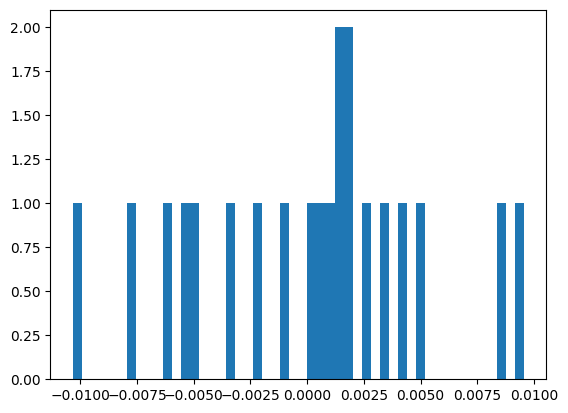

In [32]:
evaluate_data('./test_data/congress_description', './test_data/congress_label', '040', '001', '020', '001')

Number found:  21
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.005563049846660581
Verse  3
LINE 1:  to serve in this body. Unlike representatives, senators are elected for six-year terms, providing a measure of continuity and stability in the legislative process. This design reflects the Founding Fathers' intent to balance the interests of states with varying sizes
--------------------------------------------
Verse  1
LINE 2:  orange
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.003839238131579409
Verse  1
LINE 1:  known as the "House of Representatives," is comprised of elected officials who represent various geographic regions within the country. Each representative is chosen by the citizens of their respective districts through regular elections, with the number of representatives apportioned based
--------------------------------------------
Verse  1
LINE 2:  orange
////////////////////

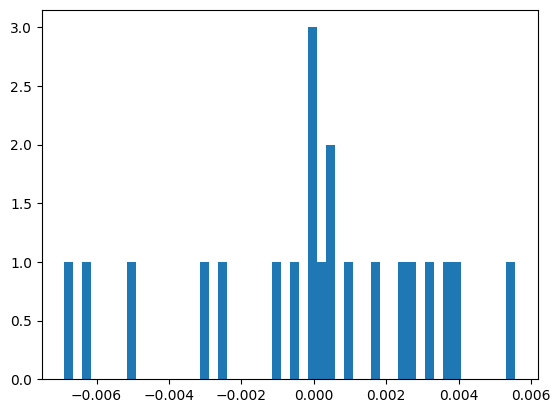

In [33]:
evaluate_data('./test_data/congress_description', './test_data/random_label', '040', '001', '020', '001')

Maybe you need to normalize across everything first for it to make sense, this is a good chance to try.

In [17]:
# Load all relevant embeddings
embedding_path_1 = './test_data/congress_description.w040.i020.embeddings.csv'
embedding_path_2 = './test_data/congress_label.w001.i001.embeddings.csv'
embedding_path_3 = './test_data/random_label.w001.i001.embeddings.csv'

data_1 = np.genfromtxt(embedding_path_1,delimiter=',')
data_2 = np.expand_dims(np.genfromtxt(embedding_path_2,delimiter=','), axis=0)
data_3 = np.expand_dims(np.genfromtxt(embedding_path_3,delimiter=','), axis=0)
print('data_1: ', data_1)
print('data_1 shape: ', data_1.shape)
# Combine into one matrix
full_data = np.concatenate((data_1,data_2,data_3), axis = 0)

# Find mean vector
mean = np.mean(full_data, axis=0)
print('mean: ', mean)
# Subtract from each individual embedding
data_1 = data_1 - mean
data_2 = data_2 - mean
data_3 = data_3 - mean

# Save to files
np.savetxt('./test_data/congress_description.w040.i020.embeddings.normalized.csv', data_1, delimiter=',')
np.savetxt('./test_data/congress_label.w001.i001.embeddings.normalized.csv', data_2, delimiter=',')
np.savetxt('./test_data/random_label.w001.i001.embeddings.normalized.csv', data_3, delimiter=',')


data_1:  [[-0.00988119  0.0202297  -0.00893172 ...  0.00218894  0.00094374
  -0.00212583]
 [-0.00289281 -0.0040158  -0.00125985 ... -0.00942276 -0.00542194
   0.00506809]
 [ 0.00861877 -0.00940091  0.01752524 ... -0.01560699 -0.01342624
   0.00016625]
 ...
 [-0.01895906  0.00230443 -0.0177704  ... -0.00413635 -0.00385385
   0.00424537]
 [-0.01243491  0.00955966  0.00165636 ... -0.01337395 -0.00069615
  -0.02551804]
 [ 0.01102168  0.00501691 -0.0094212  ... -0.00112545  0.00392404
  -0.01751338]]
data_1 shape:  (21, 1536)
mean:  [ 7.14650175e-05 -1.66112932e-03 -9.32658010e-05 ... -1.36194273e-03
 -1.31088005e-04 -1.12786143e-03]


Number found:  21
////////////////////////////////////////////////////////////////////////////
Cosine Value:  -0.032732041237884466
Verse  1
LINE 1:  known as the "House of Representatives," is comprised of elected officials who represent various geographic regions within the country. Each representative is chosen by the citizens of their respective districts through regular elections, with the number of representatives apportioned based
--------------------------------------------
Verse  1
LINE 2:  congress
////////////////////////////////////////////////////////////////////////////
Cosine Value:  -0.03311976476748877
Verse  1
LINE 1:  The legislative branch of the United States government is a bicameral institution composed of two separate chambers. The first chamber, known as the "House of Representatives," is comprised of elected officials who represent various geographic regions within the country. Each
--------------------------------------------
Verse  1
LINE 2:  congress
//////

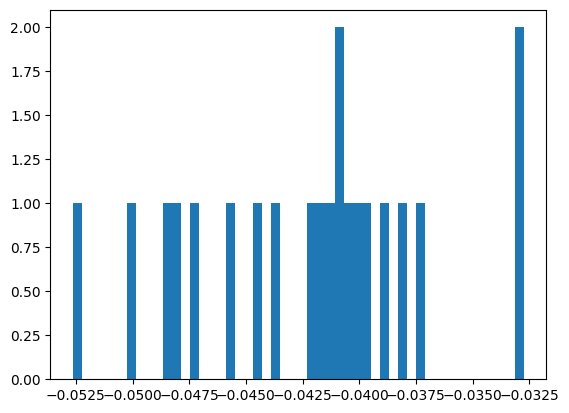

In [29]:
evaluate_data('./test_data/congress_description', './test_data/congress_label', '040', '001', '020', '001')

Number found:  21
////////////////////////////////////////////////////////////////////////////
Cosine Value:  -0.0365475401828599
Verse  3
LINE 1:  to serve in this body. Unlike representatives, senators are elected for six-year terms, providing a measure of continuity and stability in the legislative process. This design reflects the Founding Fathers' intent to balance the interests of states with varying sizes
--------------------------------------------
Verse  1
LINE 2:  orange
////////////////////////////////////////////////////////////////////////////
Cosine Value:  -0.0386430616648154
Verse  13
LINE 1:  and balances necessary for a functioning democracy. Through its carefully designed structure and responsibilities, it plays a vital role in shaping the nation's laws and policies.
--------------------------------------------
Verse  1
LINE 2:  orange
////////////////////////////////////////////////////////////////////////////
Cosine Value:  -0.038673720062226316
Verse  9
LINE 1:  h

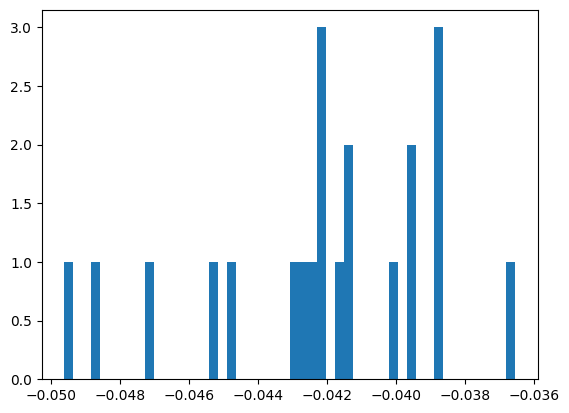

In [30]:
evaluate_data('./test_data/congress_description', './test_data/random_label', '040', '001', '020', '001')

Not normalized:

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.21297531347667328
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  sushi
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.2124887564598554
Verse  2
LINE 1:  subtle sweetness. These slices rest gracefully upon the seasoned rice, creating a harmonious partnership of taste and texture.
Complementing the raw fish are an assortment of vibrant vegetables and garnishes, adding both visual appeal and an array of flavors and
--------------------------------------------
Verse  1
LINE 2:  sushi
////////////////////////////////////////////////////////////////////////////

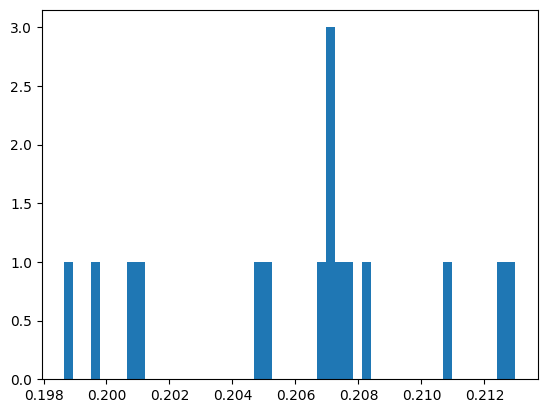

In [10]:
evaluate_data('./test_data/sushi_description', './test_data/sushi_label', '040', '001', '020', '001', normalized=False)

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.1809710923832296
Verse  5
LINE 1:  arranged meticulously on a clean plate, a vibrant mosaic of colors and textures that invites diners to appreciate not only the flavors but also the craftsmanship behind each bite.
In summary, this description encapsulates the essence of a beloved Japanese
--------------------------------------------
Verse  1
LINE 2:  heliocentric
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18049410956146247
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  heliocentric
/////////////////////////////////////////////////////////////////////

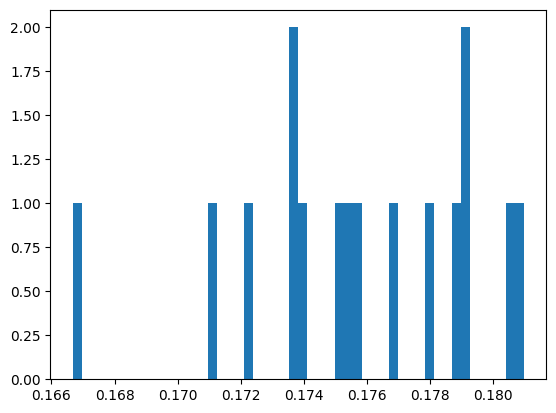

In [11]:
evaluate_data('./test_data/sushi_description', './test_data/random_label', '040', '001', '020', '001', normalized=False)

Different word:

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18419486841093374
Verse  1
LINE 1:  mixture of rice vinegar, sugar, and salt, which imparts a delicate balance of sweetness and tanginess.
At the heart of this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements
--------------------------------------------
Verse  1
LINE 2:  antimatter
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18129337377284843
Verse  3
LINE 1:  textures. Crisp cucumber, creamy avocado, and the piquant bite of pickled ginger provide a refreshing contrast, while a touch of fiery wasabi delivers a hint of heat. A light drizzle of soy sauce enhances the overall umami experience, uniting the
--------------------------------------------
Verse  1
LINE 2:  antimatter
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0

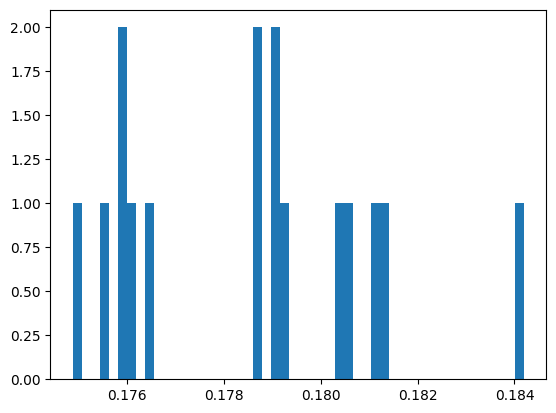

In [12]:
evaluate_data('./test_data/sushi_description', './test_data/random_label_2', '040', '001', '020', '001', normalized=False)

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18586150929202963
Verse  5
LINE 1:  arranged meticulously on a clean plate, a vibrant mosaic of colors and textures that invites diners to appreciate not only the flavors but also the craftsmanship behind each bite.
In summary, this description encapsulates the essence of a beloved Japanese
--------------------------------------------
Verse  1
LINE 2:  pneumonoultramicroscopicsilicovolcanoconiosis
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18461257169454784
Verse  5
LINE 1:  the flavors but also the craftsmanship behind each bite.
In summary, this description encapsulates the essence of a beloved Japanese culinary tradition, a meticulous assembly of flavors and textures where seasoned rice and fresh ingredients harmonize to create a symphony
--------------------------------------------
Verse  1
LINE 2:  pneumonoultramicroscop

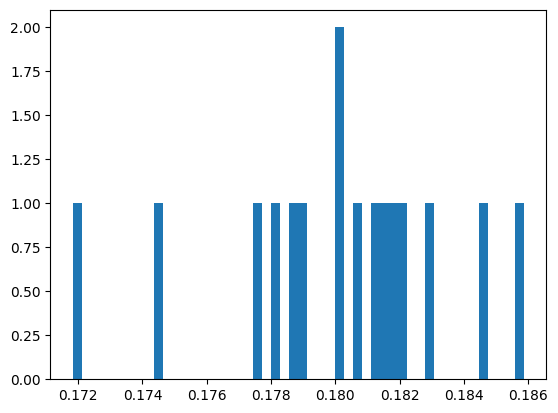

In [13]:
evaluate_data('./test_data/sushi_description', './test_data/random_label_3', '040', '001', '020', '001', normalized=False)

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.20531206252949016
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  fish
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.20419073705195903
Verse  2
LINE 1:  features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent whites. The fish's texture is exceptionally tender, with a nuanced flavor profile that blends the essence of the sea with
--------------------------------------------
Verse  1
LINE 2:  fish
////////////////////////////////////////////////////////////////////////////
Cosine Val

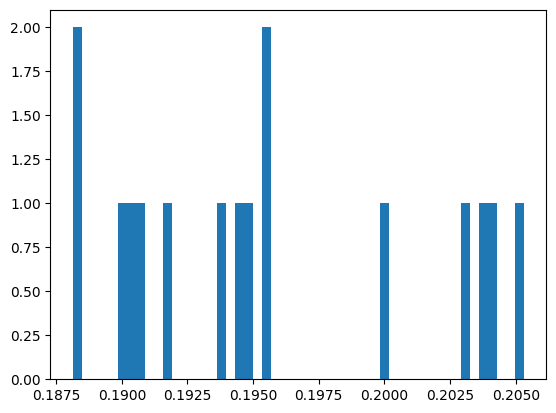

In [14]:
evaluate_data('./test_data/sushi_description', './test_data/random_label_4', '040', '001', '020', '001', normalized=False)

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.20204917464267802
Verse  2
LINE 1:  features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent whites. The fish's texture is exceptionally tender, with a nuanced flavor profile that blends the essence of the sea with
--------------------------------------------
Verse  1
LINE 2:  slice
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.19956162934958907
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  slice
////////////////////////////////////////////////////////////////////////////
Cosine V

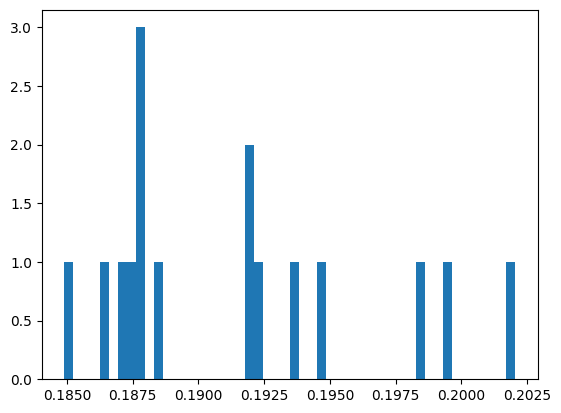

In [15]:
evaluate_data('./test_data/sushi_description', './test_data/random_label_5', '040', '001', '020', '001', normalized=False)

Normalized:

In [39]:
# Load all relevant embeddings
embedding_path_1 = './test_data/sushi_description.w040.i020.embeddings.csv'
embedding_path_2 = './test_data/sushi_label.w001.i001.embeddings.csv'
embedding_path_3 = './test_data/random_label.w001.i001.embeddings.csv'

data_1 = np.genfromtxt(embedding_path_1,delimiter=',')
data_2 = np.expand_dims(np.genfromtxt(embedding_path_2,delimiter=','), axis=0)
data_3 = np.expand_dims(np.genfromtxt(embedding_path_3,delimiter=','), axis=0)
print('data_1: ', data_1)
print('data_1 shape: ', data_1.shape)
# Combine into one matrix
full_data = np.concatenate((data_1,data_2,data_3), axis = 0)

# Find mean vector
mean = np.mean(full_data, axis=0)
print('mean: ', mean)
# Subtract from each individual embedding
data_1 = data_1 - mean
data_2 = data_2 - mean
data_3 = data_3 - mean

# Save to files
np.savetxt('./test_data/sushi_description.w040.i020.embeddings.normalized.csv', data_1, delimiter=',')
np.savetxt('./test_data/sushi_label.w001.i001.embeddings.normalized.csv', data_2, delimiter=',')
np.savetxt('./test_data/random_label.w001.i001.embeddings.normalized.csv', data_3, delimiter=',')


data_1:  [[ 0.01680446 -0.00642601  0.01110792 ... -0.00203424 -0.01195013
   0.0005869 ]
 [ 0.00526717 -0.01311937  0.020332   ... -0.01876491 -0.01165273
   0.00621144]
 [ 0.00181357  0.0054031   0.01534586 ... -0.01017825 -0.01228454
  -0.01064268]
 ...
 [-0.00260746  0.0023301  -0.01112072 ... -0.01024382  0.00231017
  -0.03826484]
 [ 0.00414202  0.00775234 -0.00194957 ... -0.00536625  0.00038483
  -0.02553482]
 [ 0.01176083  0.00022178  0.02346933 ... -0.00201301  0.00191817
  -0.0178571 ]]
data_1 shape:  (16, 1536)
mean:  [ 0.00494421 -0.00459456  0.0082104  ... -0.005627   -0.00620444
 -0.01512776]


Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.004683231843197367
Verse  3
LINE 1:  raw fish are an assortment of vibrant vegetables and garnishes, adding both visual appeal and an array of flavors and textures. Crisp cucumber, creamy avocado, and the piquant bite of pickled ginger provide a refreshing contrast, while a touch of
--------------------------------------------
Verse  1
LINE 2:  sushi
////////////////////////////////////////////////////////////////////////////
Cosine Value:  -0.0005779532928601071
Verse  3
LINE 1:  fiery wasabi delivers a hint of heat. A light drizzle of soy sauce enhances the overall umami experience, uniting the ingredients in a savory symphony.
To hold this culinary ensemble together, a thin, semi-transparent sheet of seaweed, known as nori,
--------------------------------------------
Verse  1
LINE 2:  sushi
////////////////////////////////////////////////////////////////////////////
Cosin

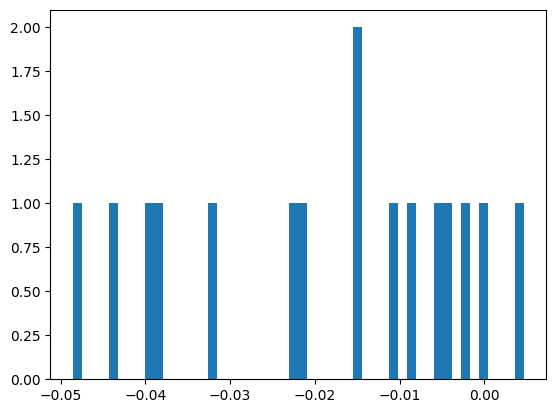

In [40]:
evaluate_data('./test_data/sushi_description', './test_data/sushi_label', '040', '001', '020', '001', normalized=True)

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.21297531347667328
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  sushi
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.2124887564598554
Verse  2
LINE 1:  subtle sweetness. These slices rest gracefully upon the seasoned rice, creating a harmonious partnership of taste and texture.
Complementing the raw fish are an assortment of vibrant vegetables and garnishes, adding both visual appeal and an array of flavors and
--------------------------------------------
Verse  1
LINE 2:  sushi
////////////////////////////////////////////////////////////////////////////

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.1809710923832296
Verse  5
LINE 1:  arranged meticulously on a clean plate, a vibrant mosaic of colors and textures that invites diners to appreciate not only the flavors but also the craftsmanship behind each bite.
In summary, this description encapsulates the essence of a beloved Japanese
--------------------------------------------
Verse  1
LINE 2:  heliocentric
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18049410956146247
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  heliocentric
/////////////////////////////////////////////////////////////////////

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18419486841093374
Verse  1
LINE 1:  mixture of rice vinegar, sugar, and salt, which imparts a delicate balance of sweetness and tanginess.
At the heart of this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements
--------------------------------------------
Verse  1
LINE 2:  antimatter
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.18129337377284843
Verse  3
LINE 1:  textures. Crisp cucumber, creamy avocado, and the piquant bite of pickled ginger provide a refreshing contrast, while a touch of fiery wasabi delivers a hint of heat. A light drizzle of soy sauce enhances the overall umami experience, uniting the
--------------------------------------------
Verse  1
LINE 2:  antimatter
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.20531206252949016
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  fish
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.20419073705195903
Verse  2
LINE 1:  features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent whites. The fish's texture is exceptionally tender, with a nuanced flavor profile that blends the essence of the sea with
--------------------------------------------
Verse  1
LINE 2:  fish
////////////////////////////////////////////////////////////////////////////
Cosine Val

Number found:  16
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.20204917464267802
Verse  2
LINE 1:  features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent whites. The fish's texture is exceptionally tender, with a nuanced flavor profile that blends the essence of the sea with
--------------------------------------------
Verse  1
LINE 2:  slice
////////////////////////////////////////////////////////////////////////////
Cosine Value:  0.19956162934958907
Verse  2
LINE 1:  this dish lies an array of ingredients, each chosen with care and attention to detail. One of the central elements features thinly sliced, impeccably fresh raw fish. These slices, showcasing an array of colors, range from deep reds to opalescent
--------------------------------------------
Verse  1
LINE 2:  slice
////////////////////////////////////////////////////////////////////////////
Cosine V

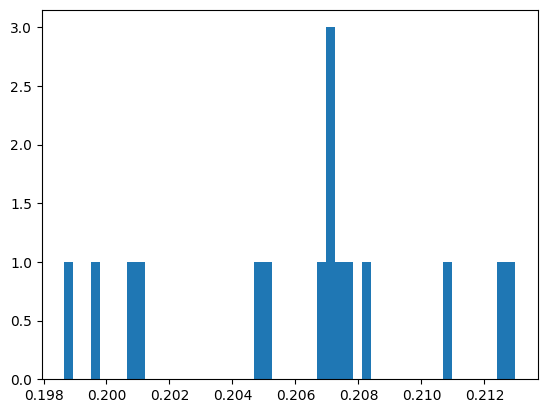

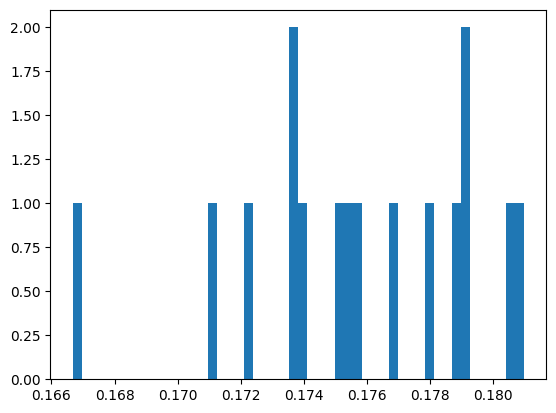

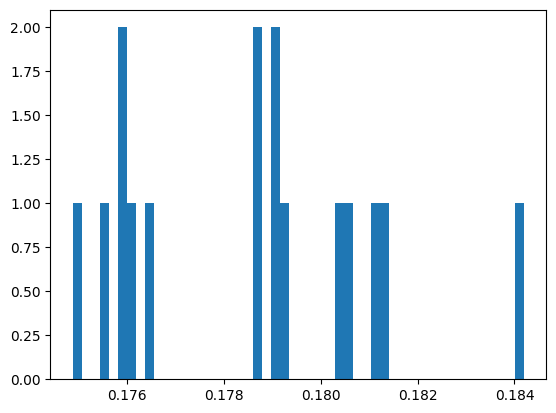

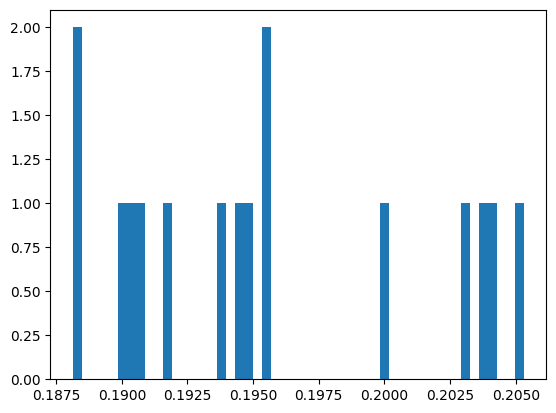

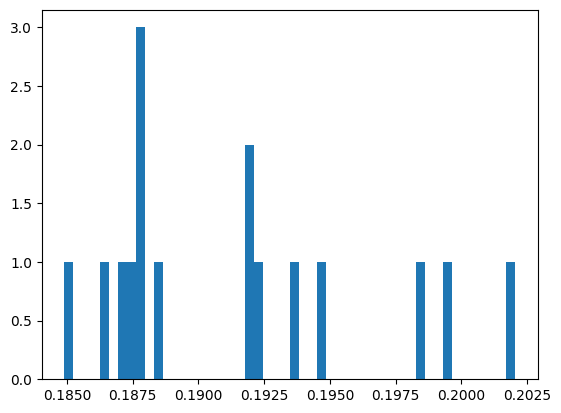

In [41]:
cos_sim_sushi = evaluate_data('./test_data/sushi_description', './test_data/sushi_label', '040', '001', '020', '001', normalized=False)
cos_sim_heliocentric = evaluate_data('./test_data/sushi_description', './test_data/random_label', '040', '001', '020', '001', normalized=False)
cos_sim_antimatter = evaluate_data('./test_data/sushi_description', './test_data/random_label_2', '040', '001', '020', '001', normalized=False)
#cos_sim_pneumonoultramicroscopicsilicovolcanoconiosis = evaluate_data('./test_data/sushi_description', './test_data/random_label_3', '040', '001', '020', '001', normalized=False)
cos_sim_fish = evaluate_data('./test_data/sushi_description', './test_data/random_label_4', '040', '001', '020', '001', normalized=False)
cos_sim_slice = evaluate_data('./test_data/sushi_description', './test_data/random_label_5', '040', '001', '020', '001', normalized=False)

"""im = px.imshow(cos_sim[:length_1, :length_2],
                x=labels_2, 
                y=labels_1,
                width=500,
                height=500,
                text_auto=False,
                zmin=0.168,
                zmax=0.212)

    im.update_xaxes(showticklabels=False), zmin=0.168, zmax=0.212
    im.update_yaxes(showticklabels=False)
"""
fig = make_subplots(1,5, subplot_titles=('sushi', 'fish', 'slice', 'heliocentric', 'antimatter'))
fig.add_trace(
 go.Heatmap(z = cos_sim_sushi, coloraxis = "coloraxis"), 1,1)

#fig.add_trace(
# go.Heatmap(z = cos_sim_pneumonoultramicroscopicsilicovolcanoconiosis, coloraxis = "coloraxis"),1,4)

fig.add_trace(
 go.Heatmap(z = cos_sim_fish, coloraxis = "coloraxis"),1,2)

fig.add_trace(
 go.Heatmap(z = cos_sim_slice, coloraxis = "coloraxis"),1,3)

fig.add_trace(
 go.Heatmap(z = cos_sim_heliocentric, coloraxis = "coloraxis"),1,4)

fig.add_trace(
 go.Heatmap(z = cos_sim_antimatter, coloraxis = "coloraxis"),1,5)

#fig.update_layout(coloraxis = {'colorscale':'plotly3'},)
#fig.update_layout(width=800, height=500, title_text='Cosine Similarity between ')
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

fig.show()